In [2]:
import sys
from time import time
from scipy import stats, sparse
from scipy.sparse.linalg import svds, eigs
from scipy.special import expit
import numpy as np
import os
import math
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import collections
import scipy
from scipy.stats import norm as dist_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from collections import defaultdict
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import pickle as pkl

#from utils import *
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#Lemur 1 = Bernard (male); Lemur 2 = Stumpy (female); Lemur 3 = Martine (female); Lemur 4 = Antoine (male)
MEDIUM_SIZE = 8
SMALLER_SIZE = 6
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)	 # fontsize of the axes title
plt.rc('xtick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
# plt.style.use('dark_background')
plt.rc('font', family='Helvetica')
plt.rc('mathtext', default='regular')
# mpl.rcParams.update({"ytick.color" : "w",
#                      "xtick.color" : "w",
#                      "axes.labelcolor" : "w",
#                      "axes.edgecolor" : "w"})
def format_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
FIG_HEIGHT = 2
FIG_WIDTH = 2
dname2keyword = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
dname2keyword_raw = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
for dname in dname2keyword_raw:
    st = dname2keyword[dname]
    dname2keyword[dname] = ''
    for i in range(len('Muris droplet') - len(st)):
        dname2keyword[dname] += ' '
    dname2keyword[dname] += st
dnames = ['muris_facs','muris_droplet','microcebusBernard','microcebusStumpy','microcebusMartine','microcebusAntoine']


/tmp/ipykernel_22718/2004482474.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_label, fontsize=SMALLER_SIZE*1.5)
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


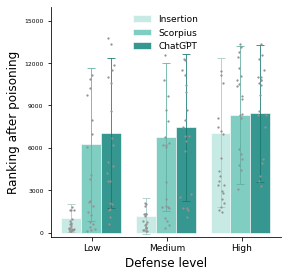

In [3]:
from math import fabs
def add_bar_plot_dots(ax, x, y, jitter=0.08):
    np.random.seed(42)
    noise = np.random.randn(len(x))
    x += jitter*noise
    # ax.scatter(x, y, c='#737373', s=6, marker='.', zorder=5)
    ax.scatter(x, y, c='#939393', s=6, marker='.', zorder=5)

def bar_plot(array, ax, n_group, n_item, methods, xtick_label, capsize=2.0, \
	     	capthick=0.8, edgecolor='white', linewidth=0.6):
	# calculate the mean and std of each group
	values = np.asarray(array)
	mean_values = np.mean(values, axis=2)
	std_values = np.std(values, axis=2)
	# sort methods, mean_values, std_values according to the mean_values
	# plot
	colors = ['#c7eae5', '#80cdc1', '#35978f', '#01665e', '#8c510a', '#bf812d', '#dfc27d', '#a6cee3']
	edge_colors = ['#a7cac5', '#60ada1', '#15776f']
	width = 1. / len(methods) * 0.8
	for i in range(len(methods)):
		ax.bar(np.arange(n_group) + i * width, mean_values[i, :], \
	 			width, color=colors[i], label=methods[i], \
				edgecolor=edgecolor, linewidth=linewidth)
		ax.errorbar(np.arange(n_group) + i * width, mean_values[i, :], \
					yerr=std_values[i, :], color=edge_colors[i], \
					capthick=capthick, fmt='none', elinewidth=capthick, capsize=capsize*2)
	dots_x, dots_y = [], []
	# ax.set_yticks([0.0,  0.1,  0.2, 0.3, 0.4])
	ax.set_ylabel('Ranking after poisoning', fontsize = SMALLER_SIZE*2)
	ax.set_xlabel('Defense level', fontsize = SMALLER_SIZE*2)

	ax.set_yticks([0,  3000,  6000, 9000, 12000, 15000])
	np.random.seed(1)
	for i in range(n_group):
		index = np.random.choice(np.arange(300), size=20, replace=False)
		for j in index: # n_item is too Congested
			dots_x.extend(np.arange(len(methods))* width + i)
			dots_y.extend(values[:, i, j])
	add_bar_plot_dots(ax, dots_x, dots_y, jitter=width*0.1)
	ax.spines['right'].set_visible(False)
	ax.spines['top'].set_visible(False)
	ax.set_xticklabels(xtick_label, fontsize=SMALLER_SIZE*1.5)
	ax.set_xticks(np.arange(n_group) + width * (len(methods) - 0.5) * 1. / 2 - 0.05)
	ax.spines['right'].set_visible(False)
	ax.spines['top'].set_visible(False)
	plt.ylim(-300, 15999)
	# plt.ylim(-0.01, 0.47)
	y0,y1 = ax.get_ylim()
	x0,x1 = ax.get_xlim()
	ax.set_aspect(abs(x1-x0)/abs(y1-y0))
	format_ax(ax)
	
edge = []
bioBART = []
ChatGPT = []
init = []
for defen in [ 0.7, 0.5, 0.3]: 
	with open(f'../DiseaseAgnostic/results/After_distmult_{defen}random.pkl', 'rb') as fl:
		tmp_edge = pkl.load(fl)
	with open(f'../DiseaseAgnostic/results/After_distmult_{defen}randombioBART.pkl', 'rb') as fl:	
		tmp_bioBART = pkl.load(fl)
	with open(f'../DiseaseAgnostic/results/After_distmult_{defen}randomsentence.pkl', 'rb') as fl:
		tmp_ChatGPT = pkl.load(fl)
	with open(f'../DiseaseAgnostic/results/Init_{defen}random.pkl', 'rb') as fl:
		tmp_init = pkl.load(fl)
	edge.append(tmp_edge)
	bioBART.append(tmp_bioBART)
	ChatGPT.append(tmp_ChatGPT)
	init.append(tmp_init)
	np.sort(edge, axis=-1)
	np.sort(bioBART, axis=-1)
	np.sort(ChatGPT, axis=-1)
	np.sort(init, axis=-1)
    
edge = np.asarray(edge)
bioBART = np.asarray(bioBART)
ChatGPT = np.asarray(ChatGPT)
init = np.asarray(init)
data = np.array([edge, bioBART, ChatGPT])
tmp_data = []
for x in data:
	tmp_x = []
	for xx in x:
		mean = np.mean(xx)
		xx = list(xx)
		xx.sort(key = lambda z: fabs(z-mean))
		tmp_x.append(xx)
	tmp_data.append(tmp_x)
data = np.array(tmp_data)
methods = ['Insertion', 'Scorpius', 'ChatGPT']
n_group= 3
n_item = 400
xtick_label = ['Low', 'Medium', 'High']
fig, ax = plt.subplots(figsize=(FIG_WIDTH*2,FIG_HEIGHT*2))
bar_plot(data, ax, n_group, n_item, methods, xtick_label)
plt.legend(loc='upper center', frameon=False,  fontsize=SMALLER_SIZE*1.5)
fig.tight_layout()
fig.savefig('fig/Fig4 f.pdf')